In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.applications.efficientnet import preprocess_input

from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt





In [ ]:
# Set your data directories
train_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/train'
val_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/val'
test_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/test'

In [ ]:
# Parameters
img_size = (224, 224)
batch_size = 32
num_classes = len(os.listdir(train_dir))

In [ ]:
# Data generators with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 520 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


In [ ]:
# Load pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze the layers of base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_generator, epochs=30, validation_data=val_generator)

Epoch 1/30
17/17 [==============================] - 223s 13s/step - loss: 0.7134 - accuracy: 0.6673 - val_loss: 0.5695 - val_accuracy: 0.7667
Epoch 2/30
17/17 [==============================] - 16s 937ms/step - loss: 0.5611 - accuracy: 0.7327 - val_loss: 0.4883 - val_accuracy: 0.7733
Epoch 3/30
17/17 [==============================] - 16s 959ms/step - loss: 0.5127 - accuracy: 0.7635 - val_loss: 0.4554 - val_accuracy: 0.7600
Epoch 4/30
17/17 [==============================] - 16s 935ms/step - loss: 0.4570 - accuracy: 0.8038 - val_loss: 0.4514 - val_accuracy: 0.7933
Epoch 5/30
17/17 [==============================] - 16s 952ms/step - loss: 0.4419 - accuracy: 0.7846 - val_loss: 0.4448 - val_accuracy: 0.7800
Epoch 6/30
17/17 [==============================] - 17s 1000ms/step - loss: 0.4251 - accuracy: 0.8212 - val_loss: 0.4506 - val_accuracy: 0.7733
Epoch 7/30
17/17 [==============================] - 17s 1s/step - loss: 0.4232 - accuracy: 0.7962 - val_loss: 0.4614 - val_accuracy: 0.7800
Ep

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

3/3 [==============================] - 21s 10s/step - loss: 0.4771 - accuracy: 0.7703
Test Accuracy: 0.7702702879905701


In [ ]:
# Generate predictions
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

3/3 [==============================] - 5s 501ms/step


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Make predictions on the test set
predictions = model.predict(test_generator)

# Convert probabilities to class labels (0 or 1)
predicted_classes = (predictions > 0.5).astype("int32").flatten()

# Get true labels
true_classes = test_generator.classes

# Compute confusion matrix
predicted_classes = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Compute classification report
class_report = classification_report(true_classes, predicted_classes, target_names=['Class 0', 'Class 1'])

# Compute precision, recall, and F1 score
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

# Print metrics
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


3/3 [==============================] - 2s 334ms/step
Confusion Matrix:
[[28  9]
 [ 8 29]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.78      0.76      0.77        37
     Class 1       0.76      0.78      0.77        37

    accuracy                           0.77        74
   macro avg       0.77      0.77      0.77        74
weighted avg       0.77      0.77      0.77        74

Precision: 0.7631578947368421
Recall: 0.7837837837837838
F1 Score: 0.7733333333333334


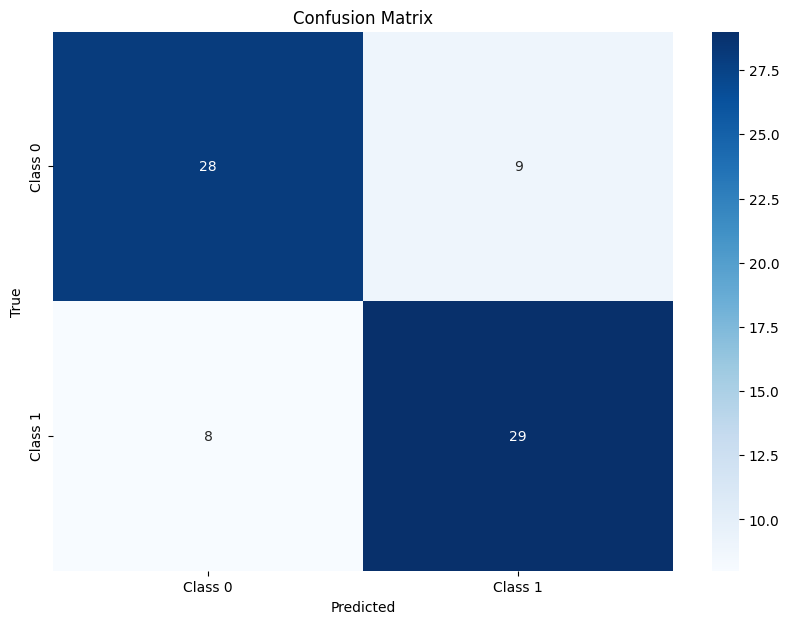

In [ ]:
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77        37
           1       0.78      0.76      0.77        37

    accuracy                           0.77        74
   macro avg       0.77      0.77      0.77        74
weighted avg       0.77      0.77      0.77        74



In [ ]:
# Save the model
model.save("efficientnet_osteo.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


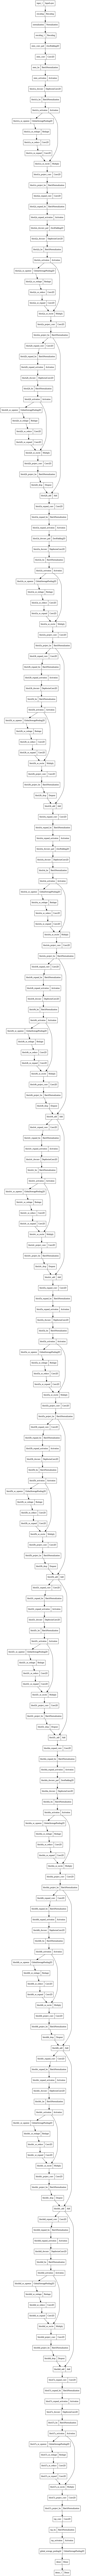

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
model = load_model('efficientnet_osteo.h5')
plot_model(model)

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=255608fb2f47ee7b444cb930ba1f6d4cd57403381ed2a645befafc607d40d2cb
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
import lime.lime_image

In [ ]:
import os
import keras
from keras.preprocessing import image
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
from tensorflow.keras.models import load_model

# Load your pre-trained CNN model
model = load_model('efficientnet_osteo.h5')

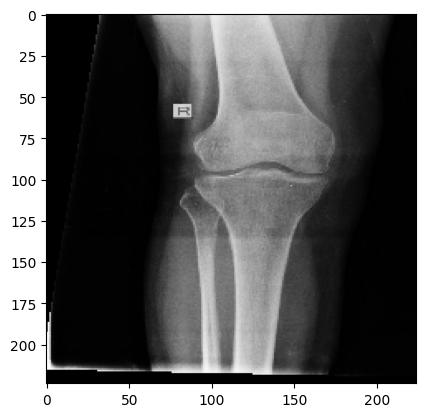

In [ ]:
img_path = (r"/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/test/osteoporosis/119.jpg")

img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
img = img/255.0


In [ ]:
preds = model.predict(img)
print(preds)

1/1 [==============================] - 3s 3s/step
[[0.13922796 0.8607721 ]]


In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(img[0].astype('double'), model.predict, top_labels=4, hide_color=0, num_samples=500)


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step
CPU times: user 8.08 s, sys: 353 ms, total: 8.43 s
Wall time: 16.1 s


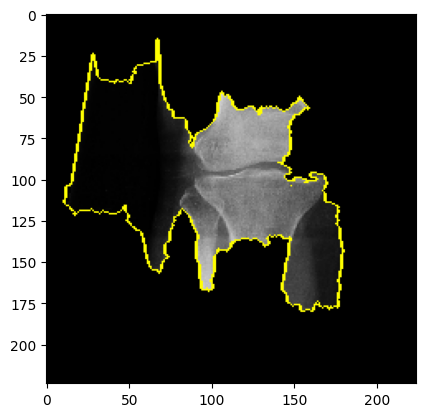

In [ ]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp , mask))

Text(0.5, 1.0, '')

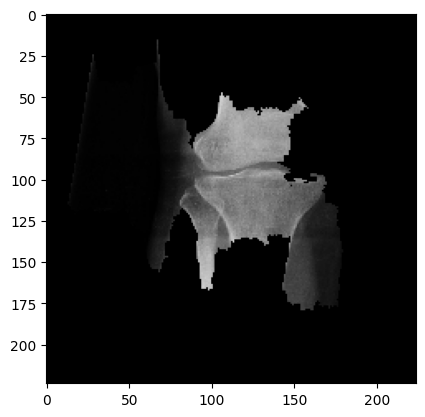

In [ ]:
plt.imshow(temp, cmap='gray')
plt.title('')

Text(0.5, 1.0, 'LIME Mask')

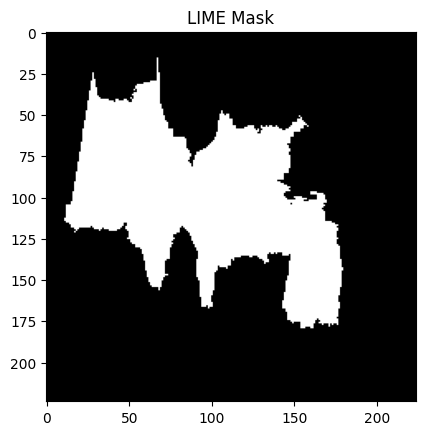

In [ ]:
plt.imshow(mask, cmap='gray')
plt.title('LIME Mask')

Text(0.5, 1.0, 'LIME Mask')

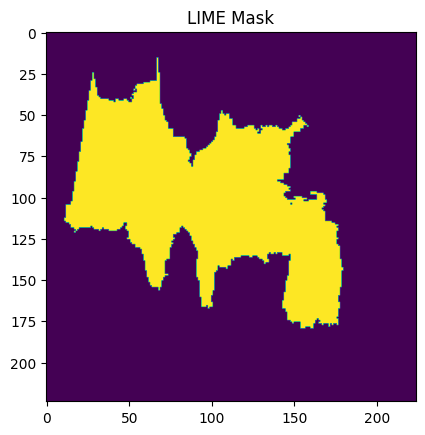

In [ ]:
plt.imshow(mask)
plt.title('LIME Mask')

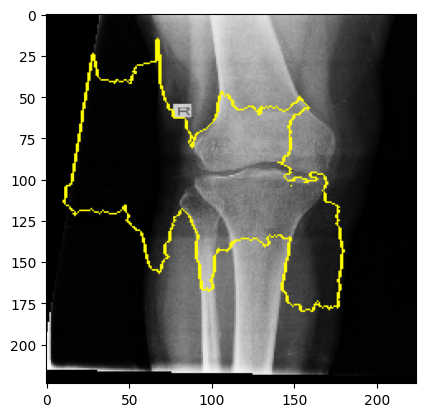

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

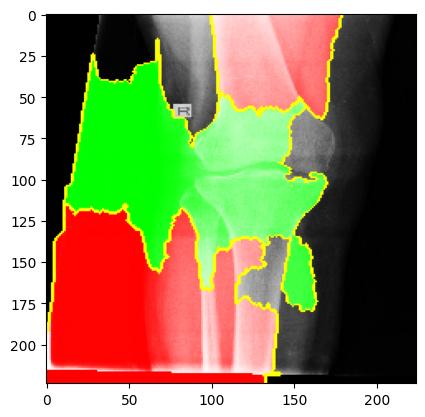

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

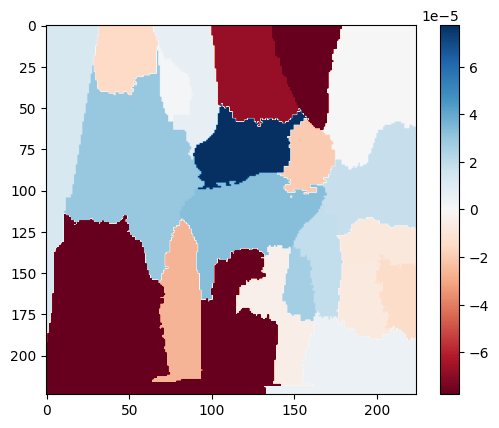

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
import tensorflow as tf

# Load your trained EfficientNet model
efficientnet_model = tf.keras.models.load_model('efficientnet_osteo.h5')


In [ ]:
import numpy as np
import cv2
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Function to preprocess images for EfficientNet
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

# Function to predict and return the probability of each class
def predict_fn(images):
    return efficientnet_model.predict(images)

# Function to apply LIME and get the explanation
def apply_lime(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img_array[0], model.predict, top_labels=1, hide_color=0, num_samples=1000)

    # Get the image and mask for the top predicted class
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    lime_img = mark_boundaries(temp / 2 + 0.5, mask)

    return lime_img, mask
'''
# Example usage
image_path = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/test/osteoporosis/175.jpg'
lime_img, mask = apply_lime(image_path, efficientnet_model)

# Save the LIME result
cv2.imwrite('lime_result.jpg', (lime_img * 255).astype(np.uint8))
'''

"\n# Example usage\nimage_path = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/test/osteoporosis/175.jpg'\nlime_img, mask = apply_lime(image_path, efficientnet_model)\n\n# Save the LIME result\ncv2.imwrite('lime_result.jpg', (lime_img * 255).astype(np.uint8))\n"

In [ ]:
def extract_roi(image_path, mask):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    roi_img = img_array * np.expand_dims(mask, axis=-1)
    return roi_img.astype('uint8')
'''
# Example usage
roi_img = extract_roi(image_path, mask)

# Save ROI image
cv2.imwrite('roi_image.jpg', roi_img)
'''

"\n# Example usage\nroi_img = extract_roi(image_path, mask)\n\n# Save ROI image\ncv2.imwrite('roi_image.jpg', roi_img)\n"

In [ ]:
import os
import shutil

def prepare_dataset(source_dir, dest_dir, model):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        dest_class_path = os.path.join(dest_dir, class_name)
        if not os.path.exists(dest_class_path):
            os.makedirs(dest_class_path)

        for img_name in os.listdir(class_path):
            image_path = os.path.join(class_path, img_name)
            lime_img, mask = apply_lime(image_path, model)
            roi_img = extract_roi(image_path, mask)
            roi_img_path = os.path.join(dest_class_path, img_name)
            cv2.imwrite(roi_img_path, roi_img)
'''
# Example usage
train_source_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/train'
train_dest_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_train'
prepare_dataset(train_source_dir, train_dest_dir, efficientnet_model)
'''
# Repeat for validation and test directories
val_source_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/val'
val_dest_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_val'
prepare_dataset(val_source_dir, val_dest_dir, efficientnet_model)

test_source_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/test'
test_dest_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_test'
prepare_dataset(test_source_dir, test_dest_dir, efficientnet_model)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 60ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 66ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 67ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 66ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


In [ ]:
# Paths to your dataset directories
train_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_train'
val_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_val'
test_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_test'

# Data augmentation and preprocessing for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocessing for validation and test sets
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Creating data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 409 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


#train_dest_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_train'

# Define a lightweight CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Single neuron for binary classification
])


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)

# Save the model
model.save('cnn_model.h5')


Epoch 1/50
13/13 [==============================] - 10s 471ms/step - loss: 0.6533 - accuracy: 0.6015 - val_loss: 0.7862 - val_accuracy: 0.5000
Epoch 2/50
13/13 [==============================] - 8s 627ms/step - loss: 0.6239 - accuracy: 0.6357 - val_loss: 0.7876 - val_accuracy: 0.5000
Epoch 3/50
13/13 [==============================] - 6s 490ms/step - loss: 0.5898 - accuracy: 0.6357 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/50
13/13 [==============================] - 8s 645ms/step - loss: 0.6431 - accuracy: 0.6088 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 5/50
13/13 [==============================] - 6s 487ms/step - loss: 0.6675 - accuracy: 0.6284 - val_loss: 0.7850 - val_accuracy: 0.5000
Epoch 6/50
13/13 [==============================] - 8s 637ms/step - loss: 0.6681 - accuracy: 0.6381 - val_loss: 0.7096 - val_accuracy: 0.5000
Epoch 7/50
13/13 [==============================] - 9s 676ms/step - loss: 0.6572 - accuracy: 0.6357 - val_loss: 0.6989 - val_accuracy: 0.5000
Epoch

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


3/3 [==============================] - 1s 263ms/step - loss: 0.5123 - accuracy: 0.7568
Test Accuracy: 75.68%


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout # Import Dropout
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import pandas as pd

Train: {'normal': 260, 'osteoporosis': 149}
Validation: {'normal': 75, 'osteoporosis': 75}
Test: {'normal': 37, 'osteoporosis': 37}


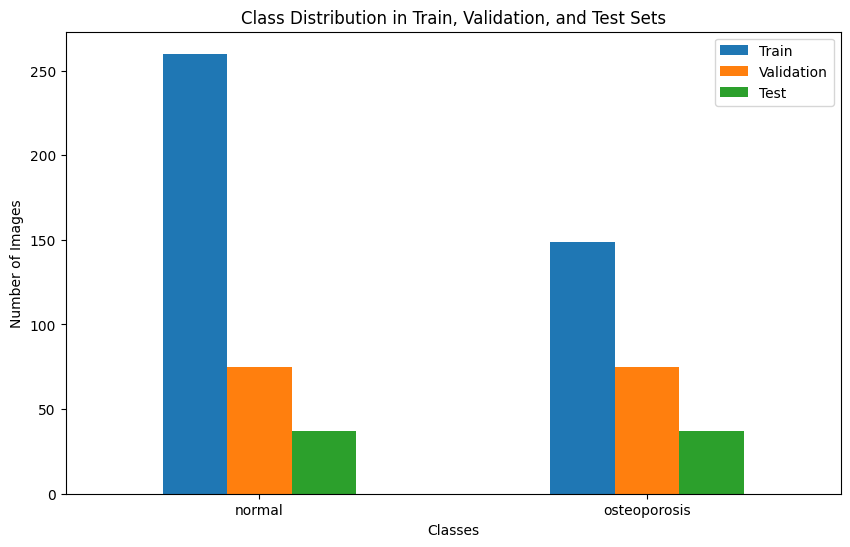

In [ ]:

train_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_train'
validation_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_val'
test_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_test'
classes = ['normal', 'osteoporosis']


def count_images(directory):
    class_counts = {}
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images(train_dir)
validation_counts = count_images(validation_dir)
test_counts = count_images(test_dir)

print("Train:", train_counts)
print("Validation:", validation_counts)
print("Test:", test_counts)

# Combine counts into a DataFrame
data = {
    'Train': train_counts,
    'Validation': validation_counts,
    'Test': test_counts
}

df_counts = pd.DataFrame(data)



# Plot the class distribution
df_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Class Distribution in Train, Validation, and Test Sets')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.show()




Train: {'normal': 260, 'osteoporosis': 149}
Validation: {'normal': 75, 'osteoporosis': 75}
Test: {'normal': 37, 'osteoporosis': 37}


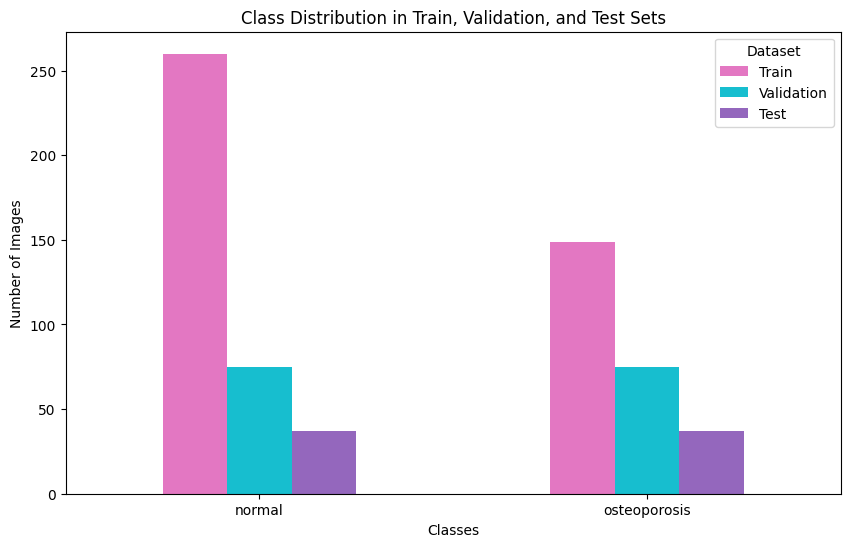

In [ ]:

train_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_train'
validation_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_val'
test_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_test'
classes = ['normal', 'osteoporosis']


def count_images(directory):
    class_counts = {}
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images(train_dir)
validation_counts = count_images(validation_dir)
test_counts = count_images(test_dir)

print("Train:", train_counts)
print("Validation:", validation_counts)
print("Test:", test_counts)

# Combine counts into a DataFrame
data = {
    'Train': train_counts,
    'Validation': validation_counts,
    'Test': test_counts
}

df_counts = pd.DataFrame(data)

custom_colors = ['#e377c2', '#17becf', '#9467bd']  # Blue, Orange, Green
custom_colors = ['#e377c2', '#17becf', '#9467bd']  # Blue, Orange, Green

# Plot the class distribution with custom colors
ax = df_counts.plot(kind='bar', figsize=(10, 6), color=custom_colors)
ax.set_title('Class Distribution in Train, Validation, and Test Sets')
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.legend(title='Dataset')
plt.show()





       Width  Height
count  409.0   409.0
mean   224.0   224.0
std      0.0     0.0
min    224.0   224.0
25%    224.0   224.0
50%    224.0   224.0
75%    224.0   224.0
max    224.0   224.0


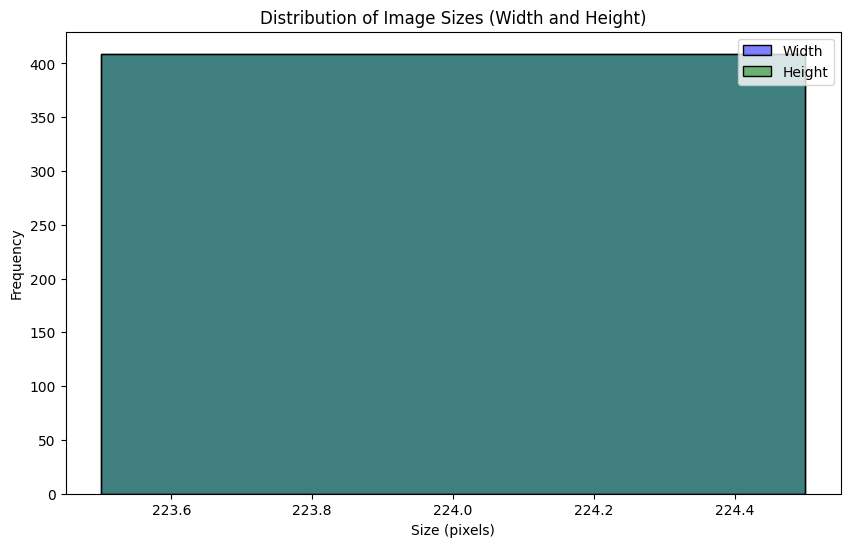

In [ ]:
def get_image_sizes(directory):
    sizes = []
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        for image_name in os.listdir(class_path):
            img_path = os.path.join(class_path, image_name)
            img = Image.open(img_path)
            sizes.append(img.size)
    return sizes

train_sizes = get_image_sizes(train_dir)
validation_sizes = get_image_sizes(validation_dir)
test_sizes = get_image_sizes(test_dir)

# Convert sizes to DataFrame for analysis
df_sizes = pd.DataFrame(train_sizes, columns=['Width', 'Height'])
print(df_sizes.describe())
plt.figure(figsize=(10, 6))
sns.histplot(df_sizes['Width'], kde=True, label='Width', color='blue')
sns.histplot(df_sizes['Height'], kde=True, label='Height', color='green')
plt.title('Distribution of Image Sizes (Width and Height)')
plt.xlabel('Size (pixels)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
# Set your data directories
train_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_train'
val_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_val'
test_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_test'
img_size = (224, 224)
batch_size = 32

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

NameError: name 'ImageDataGenerator' is not defined

In [ ]:
# Load pre-trained EfficientNetB0 model

# Parameters

img_size = (224, 224)
batch_size = 32
num_classes = 2

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze the layers of base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
# Train the model
model.fit(train_generator, epochs=50, validation_data=val_generator)

Epoch 1/50
13/13 [==============================] - 166s 12s/step - loss: 0.6519 - accuracy: 0.6601 - val_loss: 0.6975 - val_accuracy: 0.6533
Epoch 2/50
13/13 [==============================] - 41s 3s/step - loss: 0.4688 - accuracy: 0.7848 - val_loss: 0.8273 - val_accuracy: 0.7067
Epoch 3/50
13/13 [==============================] - 51s 4s/step - loss: 0.4889 - accuracy: 0.7775 - val_loss: 0.6096 - val_accuracy: 0.7467
Epoch 4/50
13/13 [==============================] - 45s 3s/step - loss: 0.4291 - accuracy: 0.7995 - val_loss: 0.6462 - val_accuracy: 0.7600
Epoch 5/50
13/13 [==============================] - 41s 3s/step - loss: 0.3999 - accuracy: 0.8166 - val_loss: 0.6309 - val_accuracy: 0.7667
Epoch 6/50
13/13 [==============================] - 42s 3s/step - loss: 0.3803 - accuracy: 0.8313 - val_loss: 0.6629 - val_accuracy: 0.7733
Epoch 7/50
13/13 [==============================] - 41s 3s/step - loss: 0.3656 - accuracy: 0.8484 - val_loss: 0.8172 - val_accuracy: 0.7333
Epoch 8/50
13/13 [

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

3/3 [==============================] - 4s 1s/step - loss: 0.3315 - accuracy: 0.9189
Test Accuracy: 0.9189189076423645


In [ ]:
# Generate predictions
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

3/3 [==============================] - 7s 2s/step


In [ ]:
# Getting predictions for ech image in test set

# Convert probabilities to class labels (0 or 1)
predicted_classes = (predictions > 0.5).astype("int32")

# Get the filenames
filenames = test_generator.filenames



# Print the predictions alongside their corresponding filenames
for filename, prediction in zip(filenames, predicted_classes):
    predicted_class = np.argmax(prediction)  # Get the index of the class with the highest probability
    print(f"{filename}: {'Class 1' if predicted_class == 1 else 'Class 0'}")

normal/131.jpg: Class 0
normal/132.png: Class 0
normal/14.png: Class 0
normal/148n.png: Class 0
normal/14nn.jpg: Class 0
normal/172n.png: Class 0
normal/174n.png: Class 0
normal/192n.png: Class 0
normal/194n.png: Class 0
normal/216n.png: Class 0
normal/218n.png: Class 0
normal/24.JPEG: Class 0
normal/265n.png: Class 0
normal/266.png: Class 0
normal/293n.jpg: Class 0
normal/294n.jpg: Class 0
normal/32nn.JPEG: Class 0
normal/38n.jpg: Class 0
normal/39.jpg: Class 0
normal/4.png: Class 0
normal/5.png: Class 0
normal/54.jpg: Class 1
normal/55.jpg: Class 1
normal/71.jpg: Class 0
normal/74.jpg: Class 0
normal/96.png: Class 0
normal/98n.jpg: Class 0
normal/Copy of 218n.png: Class 0
normal/Copy of 32nn.JPEG: Class 0
normal/Copy of 38n.jpg: Class 0
normal/Copy of 5.png: Class 0
normal/Copy of Copy of 38n.jpg: Class 0
normal/Normal.jpg: Class 0
normal/Normal_12.jpg: Class 0
normal/Normal_15.jpg: Class 0
normal/Normal_2.jpg: Class 0
normal/Normal_25.jpg: Class 0
osteoporosis/103.JPEG: Class 1
oste

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Make predictions on the test set
predictions = model.predict(test_generator)

# Convert probabilities to class labels (0 or 1)
predicted_classes = (predictions > 0.5).astype("int32").flatten()

# Get true labels
true_classes = test_generator.classes

# Compute confusion matrix
predicted_classes = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Compute classification report
class_report = classification_report(true_classes, predicted_classes, target_names=['Class 0', 'Class 1'])

# Compute precision, recall, and F1 score
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

# Print metrics
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


3/3 [==============================] - 4s 1s/step
Confusion Matrix:
[[35  2]
 [ 3 34]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      0.95      0.93        37
     Class 1       0.94      0.92      0.93        37

    accuracy                           0.93        74
   macro avg       0.93      0.93      0.93        74
weighted avg       0.93      0.93      0.93        74

Precision: 0.9444444444444444
Recall: 0.918918918918919
F1 Score: 0.9315068493150684


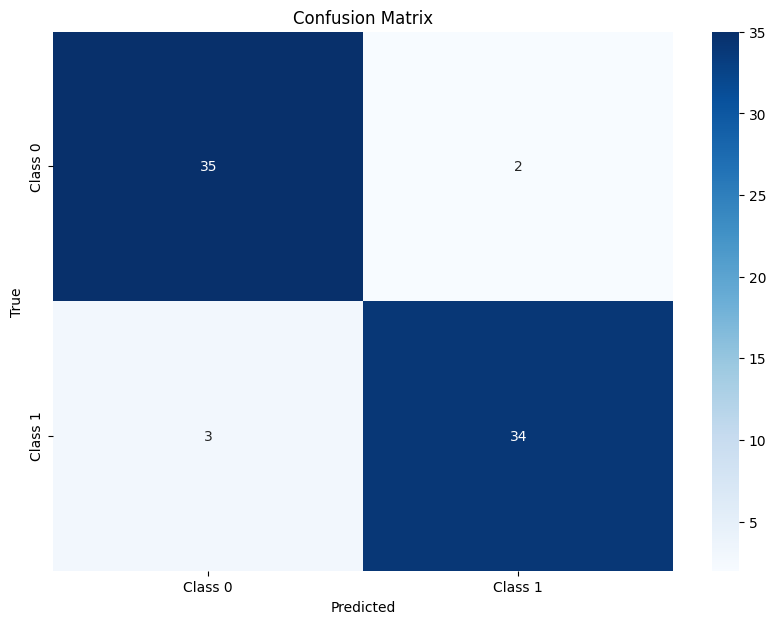

In [ ]:
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.applications.efficientnet import preprocess_input

from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

In [ ]:
# Set your data directories
train_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_train'
val_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_val'
test_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_test'
img_size = (224, 224)
batch_size = 32

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 409 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


In [ ]:
# Import models and Sequential
from tensorflow.keras import models, layers # This line is added to import models and layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
# Define the CNN model
model = models.Sequential()

# Add convolutional layers
# Changed input shape to match the generator's output shape (224, 224, 3)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu')) #Removing this convolutional layer.
#model.add(layers.MaxPooling2D((2, 2))) # Removing this max-pooling layer.
# Add fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu')) # This layer was previously receiving the wrong input shape which causes the issue.
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 10, 10, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,279,234 (27.77 MB)

 Trainable params: 7,279,234 (27.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    #steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=val_generator,
    #validation_steps=val_generator.samples // batch_size
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 517ms/step - accuracy: 0.5475 - loss: 8.8894 - val_accuracy: 0.5267 - val_loss: 0.7819
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.6755 - loss: 0.5875 - val_accuracy: 0.6600 - val_loss: 0.6320
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - accuracy: 0.6611 - loss: 0.5874 - val_accuracy: 0.7067 - val_loss: 0.5938
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step - accuracy: 0.7429 - loss: 0.5654 - val_accuracy: 0.6667 - val_loss: 0.6606
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - accuracy: 0.7764 - loss: 0.4886 - val_accuracy: 0.6933 - val_loss: 0.6900
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 277ms/step - accuracy: 0.7813 - loss: 0.4517 - val_accuracy: 0.6267 - val_loss: 0.7059
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.7363 - loss: 0.5313 - val_accuracy: 0.6133 - val_loss: 0.6728
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - accuracy: 0.7544 - loss: 0.4655 - val_accuracy: